In [49]:
# %load utils.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.metrics import roc_auc_score, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

print('Cuda:', torch.cuda.is_available())
torch.manual_seed(0)
#torch.set_deterministic(True)
np.random.seed(0)

INDIR = '../../input/'
OUTDIR = '../../output'
N_IN_CHANNELS = 3 # RGB
N_CLASSES = 2 # binary classification
BATCH_SIZE = 32
IMG_SIZE = 96
CROP_SIZE = 64

def imshow(x):
    img = x.data.cpu().permute(1, 2, 0).numpy()
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)
    plt.show()

class TumorDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = self.annotations.id[index] + '.tif'
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        y_label = torch.tensor(self.annotations.label[index])

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

class ConditionalConvVAE(nn.Module):
    def __init__(self, latent_dim, n_in_channels, n_classes):
        super(ConditionalConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes

        n_channels = 16 # tuneable hyperparam
        self.n_channels = n_channels

        self.encoder = nn.Sequential(
            nn.Conv2d(n_in_channels + n_classes, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 2, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 4, n_channels * 8, 4, 2, 1),
            nn.Flatten()
        )
        self.flat_dim = n_channels * 8 * 4 * 4

        self.mu = nn.Linear(self.flat_dim, latent_dim)
        self.logvar = nn.Linear(self.flat_dim, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim + n_classes, self.flat_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(n_channels * 8, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels * 4, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels * 2, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels, n_in_channels, 4, 2, 1),
        )

    def encode(self, input):
        # implementation goes here
        x = self.encoder(input)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        # implementation goes here
        epsilon = torch.normal(0., 1., size=mu.size()).cuda()
        std = torch.exp(logvar * 0.5)
        z = epsilon * std + mu
        return z

    def decode(self, input):
        # implementation goes here
        out = self.decoder_fc(input)
        out = out.reshape(-1, self.n_channels * 8, 4, 4)
        out = self.decoder(out)
        return out

    def forward(self, x, y):
        """
        y must be one-hot
        """
        # add n_classes as additional channels
        # num_per_batch x n_classes x 1 x 1
        channels = y.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, x.shape[-2], x.shape[-1])
        x = torch.cat((x, channels), dim=1)

        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        z = torch.cat((z, y), dim=1)

        out = self.decode(z)
        return mu, logvar, out

    def generate(self, n, y):
        """
        y must be one-hot and be of length n
        """
        z = torch.randn(n, self.latent_dim).cuda()
        z = torch.cat((z, y), dim=1)
        samples = self.decode(z)
        return samples

def vae_loss(x, out, mu, logvar, beta=1):
    # implementation goes here
    recons_loss = ((out - x) * (out - x)).sum()
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    loss = recons_loss + beta * kld_loss
    return recons_loss, kld_loss, loss

class ConditionalConvGenerator(nn.Module):
    def __init__(self, latent_dim, n_in_channels, n_classes, img_size):
        """
        assume img has same height and width
        """
        super(ConditionalConvGenerator, self).__init__()
        self.latent_dim = latent_dim

        n_channels = 16 # tuneable hyperparam
        self.n_channels = n_channels
        self.emb_size = 128
        self.flat_dim = n_channels * 8 * 4 * 4

        # to embed noise
        self.emb = nn.Embedding(n_classes, self.emb_size)
        self.decoder_fc = nn.Linear(latent_dim + self.emb_size, self.flat_dim)
        self.network = nn.Sequential(
            nn.ConvTranspose2d(n_channels * 8, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels * 4, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels * 2, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels, n_in_channels, 4, 2, 1)
        )

    def decode(self, input):
        # implementation goes here
        out = self.decoder_fc(input)
        out = out.reshape(-1, self.n_channels * 8, 4, 4)
        out = self.network(out)
        return out

    def forward(self, n, y):
        """
        y must be scalar labels
        """
        z = torch.randn(n, self.latent_dim).cuda()
        embed = self.emb(y)
        z = torch.cat((z, embed), dim=1)
        samples = self.decode(z)
        return samples

class ConditionalConvDiscriminator(nn.Module):
    def __init__(self, latent_dim, n_in_channels, n_classes, img_size):
        super(ConditionalConvDiscriminator, self).__init__()
        self.latent_dim = latent_dim

        n_channels = 16
        self.n_channels = n_channels
        self.flat_dim = n_channels * 8 * 4 * 4
        self.n_in_channels = n_in_channels

        # to embed class labels
        self.emb = nn.Embedding(n_classes, img_size * img_size)
        self.network = nn.Sequential(
            # one more channel from label
            nn.Conv2d(n_in_channels + 1, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 2, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 4, n_channels * 8, 4, 2, 1),
            nn.Flatten(),
            nn.Linear(self.flat_dim, 1) # scalar output
            # no need for sigmoid as we are using BCEWithLogitsLoss
        )

    def forward(self, x, y):
        # implementation goes here
        embed = self.emb(y).view(y.shape[0], 1, x.shape[-2], x.shape[-1])
        x = torch.cat((x, embed), dim=1)
        out = self.network(x)
        return out

def create_classifier(n_in_channels, n_channels=16):
    flat_dim = n_channels * 8 * 4 * 4
    model = nn.Sequential(
            nn.Conv2d(n_in_channels, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 2, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 4, n_channels * 8, 4, 2, 1),
            nn.Flatten(),
            nn.Linear(flat_dim, 1),
            nn.Sigmoid() # scalar output, use BCELoss
        )
    return model.cuda()


Cuda: True


In [2]:
def create_classifier(n_in_channels, n_channels=16):
    flat_dim = n_channels * 8 * 4 * 4 
    model = nn.Sequential(
            nn.Conv2d(n_in_channels, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 2, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 4, n_channels * 8, 4, 2, 1),
            nn.Flatten(),
            nn.Linear(flat_dim, 1),
            nn.Sigmoid() # scalar output, use BCELoss
        )
    return model.cuda()

In [3]:
model = create_classifier(3)

In [4]:
DIR = '../../input/'
N_IN_CHANNELS = 3 # RGB
N_CLASSES = 2 # binary classification
BATCH_SIZE = 32
IMG_SIZE = 96
CROP_SIZE = 64

transform = transforms.Compose([
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
])

dataset = TumorDataset(DIR + 'tumor_train_labels.csv',
                      DIR + 'tumor_data/', transform=transform)

dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [31]:
criterion = nn.BCELoss()
opt = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(0.5, 0.999))

In [32]:
OUTDIR = '../../output'

In [75]:
def train_classifier(epoch, model, opt, criterion, train_loader, dev_loader, writer):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.cuda()
        labels = labels.cuda()
        preds = model(data)
        loss = criterion(preds.squeeze(), labels.float())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        epoch_loss += loss.item()
        
    # end of epoch, eval on dev and record stats
    model.eval()
    with torch.no_grad():
        # a single batch
        for data, labels in dev_loader:
            x = data.cuda()
            y = labels.cuda()
            preds = model(x).squeeze()
            loss = criterion(preds, y.float())
            dev_auc = roc_auc_score(labels, preds.cpu())
    writer.add_scalars('loss', 
                       {'train': epoch_loss, 'dev': loss.item()},
                       epoch)
    writer.add_scalar('AUC/dev', dev_auc, epoch)
    # save model
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'opt_state_dict': opt.state_dict()
            }, 
        os.path.join(OUTDIR, EXPERIMENT, 'model_{}.pth'.format(epoch)))
    return dev_auc # save model with best dev auc

In [76]:
from torch.utils.tensorboard import SummaryWriter

In [77]:
EXPERIMENT = ''

In [78]:
writer = SummaryWriter(os.path.join(OUTDIR, EXPERIMENT))

In [79]:
train, dev, _ = random_split(dataset, [10, 10, len(dataset)-20],
                          generator=torch.Generator().manual_seed(0))

In [80]:
DEV_SIZE = len(dataset) // 5
DEV_SIZE = 10

In [81]:
train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev, batch_size=DEV_SIZE, shuffle=False, num_workers=4)

In [82]:
best_auc = 0
for epoch in range(10):
    dev_auc = train_classifier(epoch, model, opt, criterion, train_loader, dev_loader, writer)
    if dev_auc > best_auc: # save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'opt_state_dict': opt.state_dict()
            }, 
        os.path.join(OUTDIR, EXPERIMENT, 'best_model.pth'))
        best_auc = dev_auc 
        

In [83]:
stuff = torch.load(os.path.join(OUTDIR, EXPERIMENT, 'best_model.pth'))

In [85]:
model.load_state_dict(stuff['model_state_dict'])

<All keys matched successfully>

In [86]:
test_dataset = TumorDataset(DIR + 'tumor_test_labels.csv',
                      DIR + 'tumor_data/', transform=transform)

In [93]:
test_dataset, _ = random_split(test_dataset, [10, len(test_dataset) - 10])

In [94]:
model.eval()

Sequential(
  (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): Flatten()
  (8): Linear(in_features=2048, out_features=1, bias=True)
  (9): Sigmoid()
)

In [95]:
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset),
                         shuffle=False, num_workers=4)

In [96]:
with torch.no_grad():
    # a single batch
    for data, labels in test_loader:
        x = data.cuda()
        y = labels.cuda()
        preds = model(x).squeeze()
        loss = criterion(preds, y.float())
        auc = roc_auc_score(labels, preds.cpu())

In [97]:
auc

0.6799999999999999

In [102]:
cfmat = confusion_matrix(labels, np.where(preds.cpu() > 0.5, 1, 0))

<AxesSubplot:>

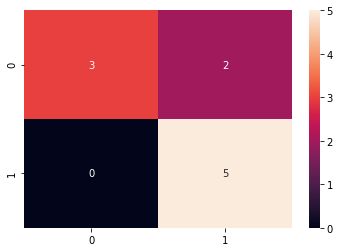

In [104]:
sns.heatmap(cfmat, annot=True)